In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import random
from scipy import stats

# Figure 3 - In vitro data analysis

## Minimum and maximum amplitude - by cycle

In [2]:
minima_df = pd.read_excel('../Data/Figure 4/Figure 4 - In vitro/Minima_Intensity_PSM4_checked.xlsx', header=[0,1])
maxima_df = pd.read_excel('../Data/Figure 4/Figure 4 - In vitro/Maxima_Intensity_PSM4_checked.xlsx', header=[0,1])

# Get the cells and experiments IDs 
experiments_id = []
cells_id = []
for i in range(1,len(maxima_df.keys())):
        if type(maxima_df.keys()[i][1])==int:
            experiments_id.append(maxima_df.keys()[i][0])
            cells_id.append(maxima_df.keys()[i][1])

In [3]:
maxima_df.head()

Experiment          419                                             \
  Cell Position           41  43           47           48           54   
0       cycle 1  1282.174552 NaN  1320.976265  1309.148889  1385.218348   
1       cycle 2  1430.265194 NaN  1290.222172  1510.000766  1545.422428   
2       cycle 3  2052.317828 NaN  1634.883916  2429.634524  1934.391662   
3       cycle 4  2429.611543 NaN  2038.696689  1765.168361  2482.386721   
4       cycle 5  1807.654612 NaN          NaN  2020.595765          NaN   

                                              ...          453               \
            56           68           70  73  ...           25           26   
0  1472.298222  1659.456011  1315.752396 NaN  ...  1333.722754  1239.597264   
1  1832.762644  1633.179714  1458.109872 NaN  ...  1391.744687  1303.194465   
2  2027.814693  1746.145412  1794.384384 NaN  ...  1659.400077  1278.472297   
3  2438.476653          NaN          NaN NaN  ...  1622.167414  1368.972797   
4          NaN          NaN          NaN NaN  ...  1307.773844  1271.424025   

                                                                    \
            27           29           33           34           35   
0  1337.962700  1246.514556  1259.907359  1332.941598  1363.436554   
1  1496.396663  1317.643745  1225.470483  1362.373213  1513.111127   
2  1361.712501  1479.045651  1522.183564  1256.282977  1385.273642   
3          NaN  1526.478076  1591.591235  1290.988725  1344.764059   
4          NaN  1523.391108  1502.135349  1319.817547  1470.531785   

                                          
            36           38           39  
0  1321.776556  1357.939970  1449.374603  
1  1555.836848  1584.093745  1465.336370  
2  1978.942609  1557.188168  1518.487472  
3          NaN  1727.237109          NaN  
4          NaN  1559.806339          NaN  

[5 rows x 185 columns]

In [4]:
n_cycles = len(maxima_df['Experiment']['Cell Position'].dropna())

min_val_cycle = {new_list: [] for new_list in range(1,n_cycles+1,)}
max_val_cycle = {new_list: [] for new_list in range(1,n_cycles+1,)}

for i in range(n_cycles):
    # For the maxima
    max_aux = np.array(maxima_df.iloc[[i]].to_numpy()[0][1:],dtype=float)
    max_val = max_aux[~np.isnan(max_aux)]
    
    max_val_cycle[i+1].append(max_val)
    
    # For the minima
    min_aux = np.array(minima_df.iloc[[i]].to_numpy()[0][1:],dtype=float)
    min_val = min_aux[~np.isnan(min_aux)]
    
    min_val_cycle[i+1].append(min_val)
        
# Convert into list arrays  
min_cycle = []
max_cycle = []

for i in range(n_cycles):
    min_cycle.append(np.array(min_val_cycle[i+1]))
    max_cycle.append(np.array(max_val_cycle[i+1]))

In [5]:
print('Cycle 1: %d cells'%len(np.array(min_val_cycle[1])[~np.isnan(np.array(min_val_cycle[1]))]))
print('Cycle 2: %d cells'%len(np.array(min_val_cycle[2])[~np.isnan(np.array(min_val_cycle[2]))]))
print('Cycle 3: %d cells'%len(np.array(min_val_cycle[3])[~np.isnan(np.array(min_val_cycle[3]))]))
print('Cycle 4: %d cells'%len(np.array(min_val_cycle[4])[~np.isnan(np.array(min_val_cycle[4]))]))
print('Cycle 5: %d cells'%len(np.array(min_val_cycle[5])[~np.isnan(np.array(min_val_cycle[5]))]))
print('Cycle 6: %d cells'%len(np.array(min_val_cycle[6])[~np.isnan(np.array(min_val_cycle[6]))]))
print('Cycle 7: %d cells'%len(np.array(min_val_cycle[7])[~np.isnan(np.array(min_val_cycle[7]))]))

Cycle 1: 172 cells
Cycle 2: 156 cells
Cycle 3: 127 cells
Cycle 4: 83 cells
Cycle 5: 42 cells
Cycle 6: 10 cells
Cycle 7: 4 cells


In [6]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

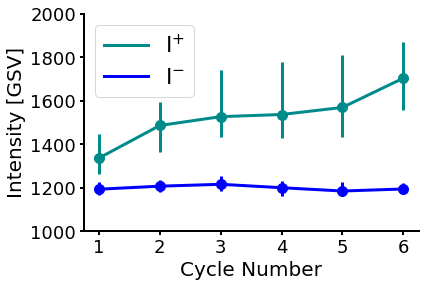

In [7]:
# Plot

fig = plt.figure(figsize=[6,4])


# Maxima
max_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(n_cycles-1):
    aux = max_cycle[i][~np.isnan(max_cycle[i])]
    max_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(max_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

# Plot ticks 
plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=16);
plt.yticks(fontsize=16)
plt.xlabel('Number of cycles', fontsize=18)
plt.ylabel('Intensity [GSV]', fontsize=18)
#plt.ylim([0,40])

inds = np.arange(0, len(medians) )
plt.plot(inds,medians, color='darkcyan', linewidth=3, label=r'I$^{+}$')
plt.scatter(inds, medians, marker='o', color='darkcyan', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='darkcyan', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='blue', linestyle='-', lw=2)


# Minima

# Remove nans for violin plot
min_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(n_cycles-1):
    aux = min_cycle[i][~np.isnan(min_cycle[i])]
    min_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(min_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(0, len(medians) )
plt.plot(inds, medians, color='blue', linewidth=3, label=r'I$^{-}$')
plt.scatter(inds, medians, marker='o', color='blue', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='blue', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='black', linestyle='-', lw=2)


plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=18);
plt.legend(loc='best', fontsize=22)
plt.yticks(fontsize=18)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Intensity [GSV]', fontsize=20)
plt.yticks(np.arange(1000,2200,200))
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

fig.savefig('../Data/Figure 4/Figure 4 - In vitro/Results/MaxMinAmplitude-Bycycle.pdf', format='pdf',bbox_inches='tight')

## Periods by cycle

In [8]:
periods_df = pd.read_excel('../Data/Figure 4/Figure 4 - In vitro/Period_PSM4_checked.xlsx', header=[0,1])
periods_df


Experiment        419                                                  \
    Position         41  43         47         48         54         56   
0      cyle1  48.288454 NaN  53.052721  60.524294  64.146771  53.195411   
1     cycle2  59.924270 NaN  57.167408  48.810628  70.867600  70.852343   
2     cycle3  72.849379 NaN  69.014149  76.917960  80.931047  75.207318   
3    cycle 4  80.300922 NaN        NaN  70.888156        NaN        NaN   
4    cycle 5  91.801489 NaN        NaN  82.658654        NaN        NaN   
5    cycle 6        NaN NaN        NaN        NaN        NaN        NaN   
6    cycle 7        NaN NaN        NaN        NaN        NaN        NaN   

                             ...        453                                   \
          68         70  73  ...         25         26         27         29   
0  59.482656  50.910230 NaN  ...  53.517623  59.622434  59.206381  61.112800   
1  65.114887  57.413072 NaN  ...  69.090453  63.070630  55.425562  60.752048   
2        NaN        NaN NaN  ...  69.301284  64.139516        NaN  61.010346   
3        NaN        NaN NaN  ...  77.490865  79.732750        NaN  79.090293   
4        NaN        NaN NaN  ...        NaN  81.139550        NaN  97.974433   
5        NaN        NaN NaN  ...        NaN        NaN        NaN  81.326745   
6        NaN        NaN NaN  ...        NaN        NaN        NaN        NaN   

                                                                     
          33         34         35         36         38         39  
0  59.247992  58.942546  58.517389  64.627422  62.993467  57.131586  
1  66.585668  58.365709  68.617604  97.520127  55.509021  74.243529  
2  66.901007  66.924255  78.032443        NaN  87.149038        NaN  
3  77.757202  77.890173  90.323769        NaN  91.482307        NaN  
4  86.113926  84.524176  96.878323        NaN        NaN        NaN  
5        NaN        NaN        NaN        NaN        NaN        NaN  
6        NaN        NaN        NaN        NaN        NaN        NaN  

[7 rows x 185 columns]

In [9]:
n_cycles = len(periods_df['Experiment']['Position'].dropna())

period_val_cycle = {new_list: [] for new_list in range(1,n_cycles+1,)}

for i in range(n_cycles):
    # For the periods
    p_aux = np.array(periods_df.iloc[[i]].to_numpy()[0][1:],dtype=float)
    p_val = p_aux[~np.isnan(p_aux)]
    
    period_val_cycle[i+1].append(p_val)
    
        
# Convert into list arrays  
period_cycle = []

for i in range(n_cycles):
    period_cycle.append(np.array(period_val_cycle[i+1]))

In [10]:
print('Cycle 1: %d cells'%len(np.array(period_val_cycle[1])[~np.isnan(np.array(period_val_cycle[1]))]))
print('Cycle 2: %d cells'%len(np.array(period_val_cycle[2])[~np.isnan(np.array(period_val_cycle[2]))]))
print('Cycle 3: %d cells'%len(np.array(period_val_cycle[3])[~np.isnan(np.array(period_val_cycle[3]))]))
print('Cycle 4: %d cells'%len(np.array(period_val_cycle[4])[~np.isnan(np.array(period_val_cycle[4]))]))
print('Cycle 5: %d cells'%len(np.array(period_val_cycle[5])[~np.isnan(np.array(period_val_cycle[5]))]))
print('Cycle 6: %d cells'%len(np.array(period_val_cycle[6])[~np.isnan(np.array(period_val_cycle[6]))]))

Cycle 1: 172 cells
Cycle 2: 156 cells
Cycle 3: 127 cells
Cycle 4: 83 cells
Cycle 5: 42 cells
Cycle 6: 10 cells


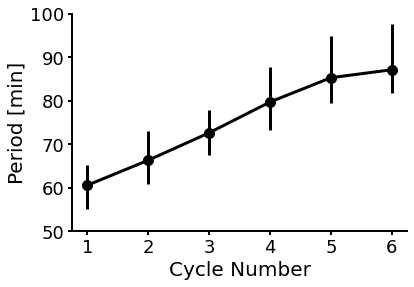

In [11]:
# Plot
fig = plt.figure(figsize=[6,4])

# Maxima
period_nan = []
quartile1 = []
quartile3 = []
medians = []
period_cycle_aux = period_cycle.copy()

for i in range(n_cycles-1):
    aux = period_cycle_aux[i][~np.isnan(period_cycle_aux[i])]
    period_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(period_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]



inds = np.arange(0, len(medians) )
plt.plot(inds,medians, color='black', linewidth=3, label='Max Amp')
plt.scatter(inds, medians, marker='o', color='black', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='red', linestyle='-', lw=3)



plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=18);
plt.yticks(np.arange(50,110,10), fontsize=18)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Period [min]', fontsize=20)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.show()

fig.savefig('../Data/Figure 4/Figure 4 - In vitro/Results/Periods-Bycycle.pdf', format='pdf', bbox_inches='tight')

## Ts by cycle

In [13]:
T_plus_df = pd.read_excel('../Data/Figure 4/Figure 4 - In vitro/T+_PSM4_checked.xlsx',header=[0,1])
T_minus_df = pd.read_excel('../Data/Figure 4/Figure 4 - In vitro/T-_PSM4_checked.xlsx',header=[0,1])
A_plus_df = pd.read_excel('../Data/Figure 4/Figure 4 - In vitro/A+_PSM4_checked.xlsx',header=[0,1])
A_minus_df = pd.read_excel('../Data/Figure 4/Figure 4 - In vitro/A-_PSM4_checked.xlsx',header=[0,1])



In [14]:
n_cycles = len(periods_df['Experiment']['Position'].dropna())

T_plus_val_cycle = {new_list: [] for new_list in range(1,n_cycles+1,)}
T_minus_val_cycle = {new_list: [] for new_list in range(1,n_cycles+1,)}


for i in range(n_cycles):
    # For the T+
    aux1 = np.array(T_plus_df.iloc[[i]].to_numpy()[0][1:],dtype=float)
    Tp = aux1[~np.isnan(aux1)]
    
    T_plus_val_cycle[i+1].append(Tp)
    
    # For the T-
    aux2 = np.array(T_minus_df.iloc[[i]].to_numpy()[0][1:],dtype=float)
    Tm = aux2[~np.isnan(aux2)]
    
    T_minus_val_cycle[i+1].append(Tm)
    
        
# Convert into list arrays  
T_plus_cycle = []
T_minus_cycle = []


for i in range(n_cycles):
    T_plus_cycle.append(np.array(T_plus_val_cycle[i+1]))
    T_minus_cycle.append(np.array(T_minus_val_cycle[i+1]))

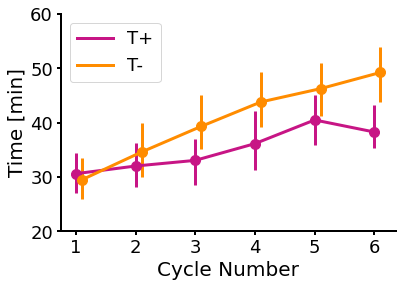

In [15]:
fig = plt.figure(figsize=[6,4])

T_plus = T_plus_cycle[:(n_cycles-1)]
T_minus = T_minus_cycle[:(n_cycles-1)]
n_cycles = n_cycles-1

# Remove nans for violin plot
T_plus_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(n_cycles):
    aux = T_plus[i][~np.isnan(T_plus[i])]
    T_plus_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(T_plus_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(0, len(medians) )
plt.plot(inds,medians, color='mediumvioletred', linewidth=3, label='T+')
plt.scatter(inds, medians, marker='o', color='mediumvioletred', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='mediumvioletred', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='blue', linestyle='-', lw=3)


# Remove nans for violin plot
T_minus_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(n_cycles):
    aux = T_minus[i][~np.isnan(T_minus[i])]
    T_minus_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(T_minus_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(0, len(medians) )+0.1
plt.plot(inds, medians, color='darkorange', linewidth=3, label='T-')
plt.scatter(inds, medians, marker='o', color='darkorange', s=100, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='darkorange', linestyle='-', lw=3)
#plt.vlines(inds, whiskersMin, whiskersMax, color='black', linestyle='-', lw=3)

# Plot ticks 
plt.xticks(np.arange(0,n_cycles,1), np.arange(1,n_cycles+1,1), fontsize=18);
plt.yticks(np.arange(20,80,10), fontsize=18)
plt.xlabel('Cycle Number', fontsize=20)
plt.ylabel('Time [min]', fontsize=20)
plt.ylim([20,60])
plt.legend(loc='upper left', fontsize=18)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
    
plt.show()

fig.savefig('../Data/Figure 4/Figure 4 - In vitro/Results/Ts-Bycycle.pdf', format='pdf', bbox_inches='tight')

### Ts per centange by cycle

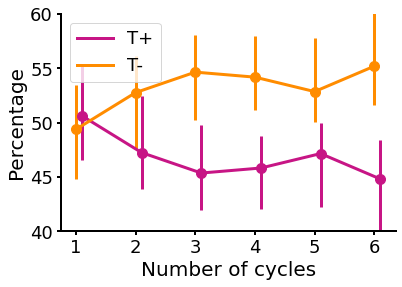

In [16]:
n_cycles = len(periods_df['Experiment']['Position'].dropna())

fig = plt.figure(figsize=[6,4])
percentage_T_plus = []
percentage_T_minus = []

quartile1_T_plus = []
quartile1_T_minus = []
quartile3_T_plus = []
quartile3_T_minus = []
medians_T_plus = []
medians_T_minus = []

for i in range(n_cycles-1):
    aux1 = T_plus[i][~np.isnan(T_plus[i])]
    aux2 = np.array(period_val_cycle[i+1][0])
    # Remove nans
    aux2 = aux2[~np.isnan(aux2)]
    
    percentage_T_plus.append((aux1/aux2)*100)
    
    quartile1_T_plus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[0])
    medians_T_plus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[1])
    quartile3_T_plus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[2])
    
    aux1 = T_minus[i][~np.isnan(T_minus[i])]
    aux2 = np.array(period_val_cycle[i+1][0])
    # Remove nans
    aux2 = aux2[~np.isnan(aux2)]
    
    percentage_T_minus.append(aux1/aux2)
    quartile1_T_minus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[0])
    medians_T_minus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[1])
    quartile3_T_minus.append(np.percentile(np.array((aux1/aux2)*100), [25, 50, 75])[2])
    
# Plot the results

# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(percentage_T_minus, quartile1_T_minus, quartile3_T_minus)])
whiskersMin_m, whiskersMax_m = whiskers[:, 0], whiskers[:, 1]

whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(percentage_T_plus, quartile1_T_plus, quartile3_T_plus)])
whiskersMin_p, whiskersMax_p = whiskers[:, 0], whiskers[:, 1]

inds_m = np.arange(0, len(medians_T_minus) )
inds_p = np.arange(0, len(medians_T_plus) )+0.1

# Plus
plt.plot(inds_p, medians_T_plus, color='mediumvioletred', linewidth=3, label='T+')
plt.scatter(inds_p, medians_T_plus, marker='o', color='mediumvioletred', s=100, zorder=3)
plt.vlines(inds_p, quartile1_T_plus, quartile3_T_plus, color='mediumvioletred', linestyle='-', lw=3)
#plt.vlines(inds_p, whiskersMin_p, whiskersMax_p, color='blue', linestyle='-', lw=2)

# Minus
plt.plot(inds_m, medians_T_minus, color='darkorange', linewidth=3, label='T-')
plt.scatter(inds_m, medians_T_minus, marker='o', color='darkorange', s=100, zorder=3)
plt.vlines(inds_m, quartile1_T_minus, quartile3_T_minus, color='darkorange', linestyle='-', lw=3)
#plt.vlines(inds_m, whiskersMin_m, whiskersMax_m, color='black', linestyle='-', lw=2)



# Plot ticks 
plt.xticks(np.arange(0,n_cycles-1,1), np.arange(1,n_cycles,1), fontsize=18);
plt.yticks(np.arange(40,65,5), fontsize=18)
plt.xlabel('Number of cycles', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.ylim([40,60])
plt.legend(loc='upper left', fontsize=18)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()
fig.savefig('../Data/Figure 4/Figure 4 - In vitro/Results/Ts_Percentage-Bycycle.pdf', format='pdf', bbox_inches='tight')

### Ts and Periods

In [17]:
len(periods_df['Experiment']['Position'].dropna())

7

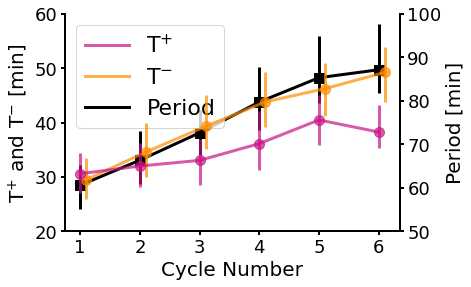

In [18]:
fig,ax = plt.subplots(figsize=[6,4])

n_cycles = len(periods_df['Experiment']['Position'].dropna())
n_cycles = n_cycles-1

T_plus_aux = T_plus_cycle.copy()
T_minus_aux = T_minus_cycle.copy()

T_plus = T_plus_aux[:(n_cycles)]
T_minus = T_minus_aux[:(n_cycles)]


#  T +
# Remove nans for violin plot
T_plus_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(n_cycles):
    aux = T_plus[i][~np.isnan(T_plus[i])]
    T_plus_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians

medians_plus = medians

# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(T_plus_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(0, len(medians) )
sc1 = plt.plot(inds,medians, color='mediumvioletred', linewidth=3, label='T$^{+}$',zorder=30,alpha=0.7)
plt.scatter(inds, medians, marker='o', color='mediumvioletred', s=100, zorder=30,alpha=0.7)
plt.vlines(inds, quartile1, quartile3, color='mediumvioletred', linestyle='-', lw=3,zorder=30,alpha=0.7)
#plt.vlines(inds, whiskersMin, whiskersMax, color='blue', linestyle='-', lw=2)


# T -

# Remove nans for violin plot
T_minus_nan = []
quartile1 = []
quartile3 = []
medians = []

for i in range(n_cycles):
    aux = T_minus[i][~np.isnan(T_minus[i])]
    T_minus_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])

medians_minus = medians

# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(T_minus_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(0, len(medians) )+0.1
sc2 = ax.plot(inds, medians, color='darkorange', linewidth=3, label='T$^{-}$',zorder=10,alpha=0.7)
ax.scatter(inds, medians, marker='o', color='darkorange', s=100, zorder=10,alpha=0.7)
ax.vlines(inds, quartile1, quartile3, color='darkorange', linestyle='-', lw=3,zorder=10,alpha=0.7)
#plt.vlines(inds, whiskersMin, whiskersMax, color='black', linestyle='-', lw=2)

# PERIOD PLOT --------------------------------

ax2=ax.twinx()

# Maxima
# Maxima
period_nan = []
quartile1 = []
quartile3 = []
medians = []
period_cycle_aux = period_cycle.copy()

for i in range(n_cycles):
    aux = period_cycle_aux[i][~np.isnan(period_cycle_aux[i])]
    period_nan.append(aux)
    quartile1.append(np.percentile(aux, [25, 50, 75])[0])
    medians.append(np.percentile(aux, [25, 50, 75])[1])
    quartile3.append(np.percentile(aux, [25, 50, 75])[2])


# Add medians
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(period_nan, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]


inds = np.arange(0, len(medians) )
sc3 = ax2.plot(inds,medians, color='black', linewidth=3, zorder=0,label='Period')
ax2.scatter(inds, medians, marker='s', color='black', s=100, zorder=0)
ax2.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=3, zorder=0)
#plt.vlines(inds, whiskersMin, whiskersMax, color='red', linestyle='-', lw=3)

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

# PLOT TICKS ----------------------------------

ax.set_xticks(np.arange(0,n_cycles,1));
ax.set_xticklabels(np.arange(1,n_cycles+1,1), fontsize=18)

ax.set_yticks(np.arange(20,80,10))
ax.set_yticklabels(np.arange(20,80,10), fontsize=18)


ax.set_xlabel('Cycle Number', fontsize=20)
ax.set_ylabel('T$^{+}$ and T$^{-}$ [min]', fontsize=20)
ax.set_ylim([20,60])
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

# Merge the legends
lns = sc1+sc2+sc3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, fontsize=22)


ax2.set_yticks(np.arange(50,110,10))
ax2.set_yticklabels(np.arange(50,110,10), fontsize=18)
ax2.set_ylim([50,100])




ax2.set_ylabel('Period [min]', fontsize=20)

ax2.tick_params(width=2, length=4)
ax2.spines['top'].set_linewidth(0)
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)

plt.show()

fig.savefig('../Data/Figure 4/Figure 4 - In vitro/Results/Ts-Period-Bycycle.pdf', format='pdf', bbox_inches='tight')